In [1]:
import os, sys
repos = os.path.dirname(os.path.dirname((os.path.abspath('optical_datasources.py'))))
sys.path.append(repos)

In [2]:
repos

'/Users/george/Repos/GitHub/Personal'

In [3]:
from gee_tools import optical_datasources as optx
from gee_tools import imgtools
import ee

In [4]:
ee.Initialize()

In [5]:
import pandas as pd

In [6]:
%matplotlib inline

# Get formatted DHS dataframe

This is just to understand better the distribution of the data within the DHS locations. This step is not necessary for the actual export.

In [7]:
home = os.path.dirname((os.path.abspath('optical_datasources.py')))

In [8]:
dhsdf = pd.read_csv(os.path.join(home, 'dhs_all_locations.csv'))

In [9]:
dhsdf.head()

,Unnamed: 0,cluster_index,lat,lon,wealth,wealthpooled,wealthpooled5country,households,urban_rural,year,country
0,0,1,14.675431,-17.440521,1.708104,1.598379,1.377751,21,1,2012,senegal
1,1,2,14.678271,-17.457794,1.679525,1.734295,1.449533,20,1,2012,senegal
2,2,3,14.710419,-17.459288,1.337672,1.421252,1.209425,21,1,2012,senegal
3,3,4,14.702820,-17.443008,2.443803,2.117576,1.828092,21,1,2012,senegal
4,4,5,14.757125,-17.478474,2.091719,1.848890,1.626253,22,1,2012,senegal


In [10]:
dhsdf.shape

(19671, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b7abbd0>]],
      dtype=object)

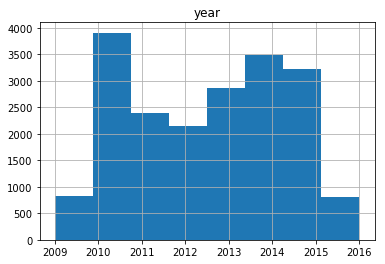

In [11]:
 dhsdf.hist('year', bins=8)

In [12]:
dfsmr = pd.DataFrame(dhsdf.groupby(['year','country']).size())

In [13]:
dfsmr2 = pd.DataFrame(dhsdf.groupby(['year']).size())

In [14]:
dfsmr2=dfsmr2.reset_index()

In [15]:
dfsmr2

,year,0
0,2009,835
1,2010,3906
2,2011,2389
3,2012,2140
4,2013,2865
5,2014,3495
6,2015,3227
7,2016,814


In [16]:
dfsmr2[dfsmr2['year'] <= 2011][0].sum()

7130

In [17]:
dfsmr2[(dfsmr2['year'] > 2011) & (dfsmr2['year'] <= 2014)][0].sum()

8500

In [18]:
dfsmr2[dfsmr2['year'] > 2014][0].sum()

4041

**Landsat launch dates are:**
 - Landsat 8: February 11, 2013 - current
 - Landsat 7: April 15, 1999 - current
 - Landsat 5: March 1, 1984 –  November 2011

Considering the distribution of data and the dates of the individual satellites, it would seem that a reasonable approach would be splitting into two 4-year groups. One from 2009 to 2012 (inclusive) the other one from 2013 to 2016 (inclusive). That way I'm splitting the "bad years" (mid 2012 to mid

# Get EE Feature Collection from DHS fusion table

NOTE: the 'dhs_all_locations.csv' file is uploaded to a Fusion Table, and lat/lon columns are set as the default location columns.

In [19]:
dhsfc = ee.FeatureCollection('ft:1lFCM5_0xgkHG2-dBKB2WCuQnFHCecO7z_4VOLrhA')

In [20]:
dhsfc.first().getInfo()

{u'geometry': {u'coordinates': [-17.4405209, 14.6754311],
  u'geodesic': True,
  u'type': u'Point'},
 u'id': u'2',
 u'properties': {u'cluster_index': 1.0,
  u'country': u'senegal',
  u'households': 21.0,
  u'indx': 0.0,
  u'lon': -17.440520907,
  u'urban_rural': 1.0,
  u'wealth': 1.70810377598,
  u'wealthpooled': 1.59837913513,
  u'wealthpooled5country': 1.37775063515,
  u'year': 2012.0},
 u'type': u'Feature'}

In [21]:
countries = dhsfc.distinct('country').aggregate_array('country').getInfo()

In [22]:
countries

[u'senegal',
 u'benin',
 u'malawi',
 u'ghana',
 u'mozambique',
 u'tanzania',
 u'ethiopia',
 u'zambia',
 u'nigeria',
 u'cote_d_ivoire',
 u'angola',
 u'burkina_faso',
 u'cameroon',
 u'uganda',
 u'zimbabwe',
 u'rwanda',
 u'drc',
 u'guinea',
 u'mali',
 u'togo',
 u'lesotho',
 u'sierra_leone',
 u'kenya']

In [23]:
cnums = range(1, len(countries)+1)
cdict = dict(zip(cnums, countries))
dhsfc = dhsfc.remap(countries, cnums, 'country')

In [24]:
dhsfc.first().getInfo()

{u'geometry': {u'coordinates': [-17.4405209, 14.6754311],
  u'geodesic': True,
  u'type': u'Point'},
 u'id': u'2',
 u'properties': {u'cluster_index': 1.0,
  u'country': 1,
  u'households': 21.0,
  u'indx': 0.0,
  u'lon': -17.440520907,
  u'urban_rural': 1.0,
  u'wealth': 1.70810377598,
  u'wealthpooled': 1.59837913513,
  u'wealthpooled5country': 1.37775063515,
  u'year': 2012.0},
 u'type': u'Feature'}

In [25]:
# cdict

In [26]:
dhsfc_oldest = dhsfc.filter(ee.Filter.lte('year', 2011))

dhsfc_middle = dhsfc.filter([ee.Filter.gt('year', 2011),
                            ee.Filter.lte('year', 2014)])

dhsfc_recent = dhsfc.filter(ee.Filter.gt('year', 2014))

In [27]:
dhsfc_oldest.size().getInfo()

7130

In [28]:
dhsfc_middle.size().getInfo()

8500

In [29]:
dhsfc_recent.size().getInfo()

4041

# Generate multi-year composites

In [30]:
selbands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP1']  # these are consistent for all Lx

### Recent branch

In [31]:
roi_recent = dhsfc_recent.geometry()
srcoll_recent = optx.LandsatSR(roi_recent, '2015-1-1', '2017-12-31').mergedqam
srmedian_recent = srcoll_recent.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_recent = imgtools.add_latlon(srmedian_recent)

### Middle Branch

In [32]:
roi_mid = dhsfc_middle.geometry()
srcoll_mid = optx.LandsatSR(roi_mid, '2012-1-1', '2014-12-31').mergedqam
# srcoll_older = srcoll_older.map(lambda img: imgtools.add_latlon(img))
srmedian_mid = srcoll_mid.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_mid = imgtools.add_latlon(srmedian_mid)

### Oldest Branch

In [33]:
roi_oldest = dhsfc_oldest.geometry()
srcoll_oldest = optx.LandsatSR(roi_oldest, '2009-1-1', '2011-12-31').mergedqam
# srcoll_older = srcoll_older.map(lambda img: imgtools.add_latlon(img))
srmedian_oldest = srcoll_oldest.select(selbands).median().reproject('EPSG:3857', None, 30)
srmedian_oldest = imgtools.add_latlon(srmedian_oldest)

# Add nightlights

In [34]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")
dmsp = ee.ImageCollection("NOAA/DMSP-OLS/CALIBRATED_LIGHTS_V4")

In [35]:
nlband = ['NIGHTLIGHTS']
viirs_recent = viirs.filterDate('2015-1-1', '2017-12-31').median().select([0],nlband)
viirs_mid = viirs.filterDate('2012-1-1', '2014-12-31').median().select([0],nlband)
dmsp_oldest = dmsp.filterDate('2009-1-1', '2011-12-31').median().select([0],nlband)

In [36]:
srmedian_recent = srmedian_recent.addBands(viirs_recent.reproject('EPSG:3857', None, 30))
srmedian_mid = srmedian_mid.addBands(viirs_mid.reproject('EPSG:3857', None, 30))
srmedian_oldest = srmedian_oldest.addBands(dmsp_oldest.reproject('EPSG:3857', None, 30))

# Add topography

In [37]:
dem = ee.Image("USGS/SRTMGL1_003");

In [38]:
tbands = ['ELEV','SLO', 'ASP']
topogr = ee.Algorithms.Terrain(dem).select(['elevation', 'slope', 'aspect'], tbands);

In [39]:
srmedian_recent = srmedian_recent.addBands(topogr.reproject('EPSG:3857', None, 30))
srmedian_mid = srmedian_mid.addBands(topogr.reproject('EPSG:3857', None, 30))
srmedian_oldest = srmedian_oldest.addBands(topogr.reproject('EPSG:3857', None, 30))

# Create TF records from DHS locations

In [40]:
from gee_tools.ai_io import ee_tf_exports as tfexp

### Testing single patch from composite

In [41]:
kern = ee.Kernel.square(5,'pixels')
# kern = ee.Kernel.square(127,'pixels')
patches_array = srmedian_recent.neighborhoodToArray(kern)
pt = ee.Feature(dhsfc_recent.first())
samplep = tfexp._sample_patch(pt, patches_array, 30)

In [42]:
samplep.getInfo()

{u'geometry': None,
 u'id': u'0',
 u'properties': {u'ASP': [[333, 320, 346, 9, 11, 11, 0, 0, 14, 64, 53],
   [304, 323, 351, 338, 346, 0, 18, 14, 11, 18, 51],
   [304, 323, 351, 338, 346, 0, 18, 14, 11, 18, 51],
   [270, 346, 342, 349, 338, 0, 22, 18, 23, 18, 21],
   [0, 0, 0, 0, 344, 0, 23, 17, 20, 17, 13],
   [349, 353, 7, 0, 344, 0, 29, 31, 14, 6, 7],
   [347, 347, 354, 352, 353, 13, 29, 37, 18, 352, 338],
   [347, 354, 355, 354, 0, 5, 18, 31, 14, 337, 315],
   [356, 0, 0, 356, 4, 11, 11, 11, 0, 331, 324],
   [4, 352, 355, 0, 9, 15, 354, 352, 9, 333, 319],
   [352, 342, 351, 0, 355, 352, 351, 352, 11, 329, 323]],
  u'BLUE': [[0.055600000000000004,
    0.057300000000000004,
    0.05500000000000001,
    0.0543,
    0.054650000000000004,
    0.05285,
    0.0519,
    0.0514,
    0.056600000000000004,
    0.0594,
    0.06685],
   [0.06330000000000001,
    0.0579,
    0.054400000000000004,
    0.05505,
    0.05500000000000001,
    0.0568,
    0.0582,
    0.0608,
    0.059800000000000006,


### Exporting array patches (i.e. full tile in array form) from DHS locations

In [43]:
dhsinfo = dhsfc_recent.first().propertyNames().getInfo()

In [44]:
bands = selbands+dhsinfo+['LAT', 'LON']+tbands+nlband

In [45]:
bands

['BLUE',
 'GREEN',
 'RED',
 'NIR',
 'SWIR1',
 'SWIR2',
 'TEMP1',
 u'wealth',
 u'country',
 u'year',
 u'indx',
 u'urban_rural',
 u'wealthpooled',
 u'cluster_index',
 u'lon',
 u'households',
 u'wealthpooled5country',
 u'system:index',
 'LAT',
 'LON',
 'ELEV',
 'SLO',
 'ASP',
 'NIGHTLIGHTS']

In [29]:
# test = tfexp.get_array_patches(srmedian_mid, 30, 127, dhsfc_middle, 
#                      True, True, bands, None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2012-14_dhslocs_arrays_v3')

In [30]:
# test = tfexp.get_array_patches(srmedian_recent, 30, 127, dhsfc_recent, 
#                      True, True, bands, None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2015-17_dhslocs_arrays_v3')

In [31]:
# test = tfexp.get_array_patches(srmedian_oldest, 30, 127, dhsfc_oldest, 
#                      True, True, bands, None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2009-11_dhslocs_arrays_v3')

In [32]:
# test.getInfo()

#### Exporting individual countries

In [49]:
dhsfc_oldest_cnums = dhsfc_oldest.distinct('country').aggregate_array('country').getInfo()

for n in dhsfc_oldest_cnums:
    
    cname = cdict[n]
    fname = 'lx_median_2009-11_'+cname+'_dhslocs_arrays_v3'
    
    seldhs = dhsfc_oldest.filter(ee.Filter.eq('country',n))
    
    bands = selbands+dhsinfo+['LAT', 'LON']+tbands+nlband
    
    test = tfexp.get_array_patches(srmedian_oldest, 30, 127, seldhs, 
                                   True, True, bands, None, 
                                   'eetf_io_tests',
                                   'LabeledPatches/', 
                                   fname)

In [47]:
dhsfc_middle_cnums = dhsfc_middle.distinct('country').aggregate_array('country').getInfo()

for n in dhsfc_middle_cnums[2:]:
    
    cname = cdict[n]
    fname = 'lx_median_2012-14_'+cname+'_dhslocs_arrays_v3'
    
    seldhs = dhsfc_middle.filter(ee.Filter.eq('country',n))
    
    bands = selbands+dhsinfo+['LAT', 'LON']+tbands+nlband
    
    test = tfexp.get_array_patches(srmedian_mid, 30, 127, seldhs, 
                                   True, True, bands, None, 
                                   'eetf_io_tests',
                                   'LabeledPatches/', 
                                   fname)

In [48]:
dhsfc_recent_cnums = dhsfc_recent.distinct('country').aggregate_array('country').getInfo()

for n in dhsfc_recent_cnums:
    
    cname = cdict[n]
    fname = 'lx_median_2015-17_'+cname+'_dhslocs_arrays_v3'
    
    seldhs = dhsfc_recent.filter(ee.Filter.eq('country',n))
    
    bands = selbands+dhsinfo+['LAT', 'LON']+tbands+nlband
    
    test = tfexp.get_array_patches(srmedian_recent, 30, 127, seldhs, 
                                   True, True, bands, None, 
                                   'eetf_io_tests',
                                   'LabeledPatches/', 
                                   fname)

### Exporting reduced patches (i.e. tile stats) from DHS locations

In [44]:
redubands = [item for sublist in [[b+'_mean', b+'_variance'] for b in selbands] for item in sublist]

In [45]:
redubands

['BLUE_mean',
 'BLUE_variance',
 'GREEN_mean',
 'GREEN_variance',
 'RED_mean',
 'RED_variance',
 'NIR_mean',
 'NIR_variance',
 'SWIR1_mean',
 'SWIR1_variance',
 'SWIR2_mean',
 'SWIR2_variance',
 'TEMP1_mean',
 'TEMP1_variance']

In [46]:
# test = tfexp.get_reduced_patches(srmedian_mid, 30, 127, dhsfc_middle, 
#                      True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2012-14_dhslocs_stats_v2')

In [47]:
# test = tfexp.get_reduced_patches(srmedian_recent, 30, 127, dhsfc_recent, 
#                      True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2015-17_dhslocs_stats_v2')

In [48]:
# test = tfexp.get_reduced_patches(srmedian_oldest, 30, 127, dhsfc_oldest, 
#                      True, True, redubands+dhsinfo+['LAT', 'LON'], None, 'eetf_io_tests', 
#                      'LabeledPatches/', 'lx_median_2009-11_dhslocs_stats_v2')